In [1]:
# load libraries
import yaml
import lightgbm
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import numpy as np
import os
import pandas as pd
import pickle
os.chdir('/home/desktop3/itu')
path = os.getcwd()
print(path)

/home/desktop3/itu


/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Loading the Thailand Data

In [7]:
# read in (yaml) configs
with open(path + '/conf/model_config.yaml', 'r') as conf:
    model_config = yaml.safe_load(conf)

# import data
dataset = model_config['model']['loc'] + model_config['model']['file']
dataset = pd.read_csv(dataset)

# define predictors and target
predictor   =  ['avg_d_kbps',
       'avg_u_kbps',
       'mean_ghm', 'avg_rad_mean',  'cf_cvg_mean',  'slope_avg_rad',
       'slope_cf_cvg', 'slope_month_avg_rad',
       'slope_monthcf_cvg', 'estimate_mau', 'value_norm']
target = ['A4A_right']

 Current issue is that predictors are named differently in Thailand than in Brazil dataset and also, 
it needs to be the same exact predictors used for both

In [8]:
dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'School', 'source_school_id', 'ENUM',
       'H107', 'lon', 'lat', 'range', 'samples', 'avg_d_kbps', 'avg_u_kbps',
       'avg_d_kbps3', 'avg_u_kbps3', 'avg_rad_mean', 'cf_cvg_mean',
       'slope_avg_rad', 'change_avg_rad', 'slope_cf_cvg', 'change_cf_cvg',
       'slope_monthcf_cvg', 'change_monthcf_cvg', 'slope_month_avg_rad',
       'change_month_avg_rad', 'slope_NDVI', 'change_NDVI', 'mean_ghm',
       'estimate_dau', 'estimate_mau', 'estimate_ready', 'value',
       'value_norm'],
      dtype='object')

In [12]:
dataset

,Unnamed: 0,Unnamed: 0.1,School,source_school_id,ENUM,H107,lon,lat,range,samples,...,slope_month_avg_rad,change_month_avg_rad,slope_NDVI,change_NDVI,mean_ghm,estimate_dau,estimate_mau,estimate_ready,value,value_norm
0,0,0,POINT (98.2554367 8.6658159),255542593,11.0,1.0,98.257309,8.666424,1.0,1.0,...,0.008125,0.008125,-63.107123,-63.107123,0.556310,4835,5900,True,254.46342,0.804133
1,1,1,POINT (100.5637277 13.7281689),280389453,11.0,1.0,100.563824,13.728090,1.0,12.0,...,0.154787,0.154787,-124.015608,-124.015608,0.891303,1040046,1600000,True,13295.45700,0.908735
2,2,2,POINT (99.3090438 6.4918845),321664554,11.0,1.0,99.309902,6.491847,1.0,4.0,...,0.003737,0.003737,132.490023,132.490023,0.348923,0,0,False,109.93822,0.802974
3,3,3,POINT (98.99020710000001 18.8422541),336232077,14.0,1.0,98.990578,18.842300,1.0,1.0,...,0.029212,0.029212,-52.833499,-52.833499,0.773788,237917,330000,True,1407.96750,0.813386
4,4,4,POINT (102.773318 16.4357572),373156854,14.0,1.0,102.774895,16.435555,1.0,22.0,...,0.023249,0.023249,19.408091,19.408091,0.819569,42591,58000,True,548.45380,0.806492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4718,4718,4718,POINT (101.2758538 14.2842555),8879142203,11.0,1.0,101.275375,14.284611,1.0,3.0,...,0.012734,0.012734,43.746437,43.746437,0.599212,10540,14000,True,145.64415,0.803261
4719,4719,4719,POINT (105.4027044 14.9497545),8905212408,11.0,1.0,105.407876,14.950656,1.0,7.0,...,0.001070,0.001070,22.923611,22.923611,0.477034,1486,1700,True,37.91742,0.802397
4720,4720,4720,POINT (100.2320763 16.8519458),8908633917,14.0,1.0,100.231919,16.851753,1.0,11.0,...,0.005698,0.005698,27.090730,27.090730,0.799692,89652,120000,True,1028.61450,0.810343
4721,4721,4721,POINT (99.82662910000001 19.904528),8931699084,14.0,1.0,99.826927,19.904137,1.0,4.0,...,0.048839,0.048839,-143.544324,-143.544324,0.772304,97046,130000,True,2506.85130,0.822200


In [9]:
# prepare data
X = dataset[predictor]
# y = dataset[target]
print('X Shape:', X.shape)
# print('y Shape:', y.shape)

X Shape: (4723, 11)


### Reloading saved pickel model

In [10]:
import mlflow
logged_model = 'file:///files/mlruns/71/06019fe25ad0491b8556bcdff1353dda/artifacts/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
y_pred = loaded_model.predict(X)

In [11]:
y_pred

array([0.64617398, 0.77537008, 0.68195516, ..., 0.58998065, 0.72081414,
       0.73123383])

## Evaluating the Model
Can't do the below because don't have ground truth on the same level

In [12]:
# Absolute error
errors = abs(y_pred - y.iloc[:,0].to_numpy())
avg_error = np.mean(errors)

#Low tail error
errors_low = abs(y_pred[y_pred<0.3] - np.asarray(y[y_pred<0.3]).flatten())

#Low tail error
errors_low_ytest = abs(y_pred[np.asarray(y).flatten()<0.3] - np.asarray(y[np.asarray(y).flatten()<0.3]).flatten())

#avg error
avg_error_low = np.mean(errors_low)


#avg error
avg_error_low_ytest = np.mean(errors_low)

#standard deviation
stan_dev_low= np.std(errors_low)

print('errors: ', errors)
print('avg error: ', avg_error)
# print('Just the lower errors: ', errors_low)
print('Mean lower error: ', avg_error_low)
print('Mean ytest lower error: ', avg_error_low_ytest)
# print('y test error: ', errors_low_ytest)
print('Standard Dev of Low Error: ', stan_dev_low)

NameError: name 'y' is not defined

In [15]:
# Absolute error
errors = abs(y_pred - y.iloc[:,0].to_numpy())
avg_error = np.mean(errors)

#Low tail error
errors_low = abs(y_pred[y_pred<0.5] - np.asarray(y[y_pred<0.5]).flatten())

#Low tail error
errors_low_ytest = abs(pred[np.asarray(y).flatten()<0.5] - np.asarray(y[np.asarray(y).flatten()<0.5]).flatten())

#avg error
avg_error_low = np.mean(errors_low)


#avg error
avg_error_low_ytest = np.mean(errors_low)

#standard deviation
stan_dev_low= np.std(errors_low)

print('errors: ', errors)
print('avg error: ', avg_error)
# print('Just the lower errors: ', errors_low)
print('Mean lower error: ', avg_error_low)
print('Mean ytest lower error: ', avg_error_low_ytest)
# print('y test error: ', errors_low_ytest)
print('Standard Dev of Low Error: ', stan_dev_low)

NameError: name 'pred' is not defined

In [16]:
dataset.head(n=3)

,Unnamed: 0,Unnamed: 0.1,School,source_school_id,ENUM,H107,lon,lat,range,samples,...,change_month_avg_rad,slope_NDVI,change_NDVI,mean_ghm,estimate_dau,estimate_mau,estimate_ready,value,value_norm,Predictions
0,0,0,POINT (98.2554367 8.6658159),255542593,11.0,1.0,98.257309,8.666424,1.0,1.0,...,0.008125,-63.107123,-63.107123,0.556310,4835,5900,True,254.46342,0.804133,0.646174
1,1,1,POINT (100.5637277 13.7281689),280389453,11.0,1.0,100.563824,13.728090,1.0,12.0,...,0.154787,-124.015608,-124.015608,0.891303,1040046,1600000,True,13295.45700,0.908735,0.775370
2,2,2,POINT (99.3090438 6.4918845),321664554,11.0,1.0,99.309902,6.491847,1.0,4.0,...,0.003737,132.490023,132.490023,0.348923,0,0,False,109.93822,0.802974,0.681955


In [15]:
#Amount of people living in our school districts
dataset['value'].sum()

2733032.9890957996

## Mapping out the Predictions

In [13]:
#Adding the predictions as a column to the dataset
dataset['Predictions']= y_pred

In [27]:
#Creating a geodataframe
from shapely import wkt
#Changing dataframe into a geodataframe focused on the school geometry column
dataset['School'] = geopandas.GeoSeries.from_wkt(dataset['School'])
gdf = geopandas.GeoDataFrame(dataset, geometry='School')

In [53]:
gdf.shape

(4723, 33)

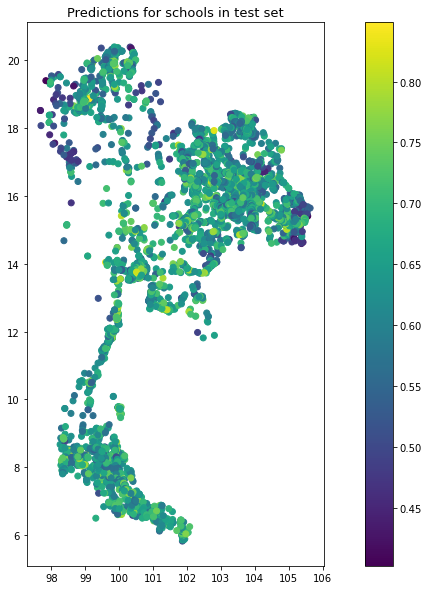

In [35]:
#Set the figure size
fig,ax =plt.subplots(1, figsize=(15,10))

#plotting with the new geodataframe, each school point by prediction value
gdf.plot(column="Predictions", cmap = 'viridis' ,legend=True, ax=ax)

# add a title and annotation
plt.suptitle('Predictions for all Thailand schools', fontsize=18, fontweight=3)
plt.title('4723 schools', fontsize=13)

#show the plot
plt.show()

## Schools below 50% because there were no schools below 30%

In [42]:
Low_pred = gdf.loc[gdf['Predictions']<.5]
Low_pred.shape

(97, 33)

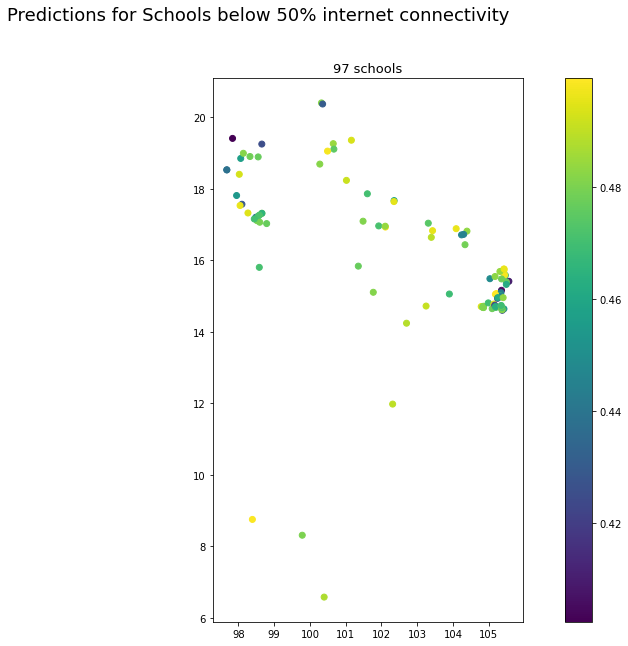

In [52]:
fig,ax =plt.subplots(1, figsize=(15,10))

# add a title and annotation
# ax.set_title('Predictions for Schools below 50% internet connectivity', fontdict={'fontsize': '13', 'fontweight' : '3'})
# ax.set_suptitle('69 schools')

Low_pred.plot(column="Predictions", cmap = 'viridis' ,legend=True, ax=ax)
plt.suptitle('Predictions for Schools below 50% internet connectivity', fontsize=18, fontweight=3)
plt.title('97 schools', fontsize=13)

plt.show()